## Incremental learning with River

In [721]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from river import metrics
from sklearn.svm import OneClassSVM
import sys
from sklearn.metrics import roc_auc_score, f1_score
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import random
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler
from predict import binarize
import os

In [3]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [4]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [5]:
# define hyperparameters and data
features_to_keep = 79
neighbors = 41
y_train = binarize(labels_train)
log_reg = LogisticRegression(C = 12.5) 
y_train = binarize(labels_train)
log_reg.fit(X_train, y_train)
sorted_feature_indices = np.argsort(log_reg.coef_[0])[::-1] # get the indices of the most important features in descending order

In [6]:
# dimensionality reduction (to stabilize KNN and avoid dimensionality curse)
indices = sorted_feature_indices[:features_to_keep]
X_train_top_feats = X_train[:, indices]
X_test_top_f = X_test[:, indices]
y_test = binarize(labels_test)

In [7]:
def plot_roc(true_y, y_prob, method_name):
    fpr, tpr, _ = roc_curve(true_y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2  # Line width
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {method_name}')
    plt.legend(loc="lower right")
    plt.show()

### Recreate original dataset

In [8]:
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [9]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [10]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [11]:
indices = sorted_feature_indices[:features_to_keep]
data_all_top = data_all[:, indices] 
healthy_data = data_all_top[y_all == 0]
damage_data = data_all_top[y_all == 1]
healthy_data.shape, damage_data.shape

((288, 79), (324, 79))

In [12]:
# for occ labels are defined differently
damage_labels  = -1*np.ones(damage_data.shape[0])
healthy_labels =    np.ones(healthy_data.shape[0])

In [919]:
def fill_between_plot(x_range, average_obs, std_obs, label, title):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    for idx, (avg_obs, std_ob) in enumerate(zip(average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color = colors[idx+2], label=label)
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx+2], alpha=0.5, label='1 std dev')
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(label)
    plt.legend()
    plt.show()

In [936]:
def fill_between_plot_diffx(x_ranges, average_obs, std_obs, label, title, labely):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    
    # Ensure that x_ranges, average_obs, and std_obs have the same length
    if not (len(x_ranges) == len(average_obs) == len(std_obs)):
        raise ValueError("Length of x_ranges, average_obs, and std_obs must be the same")

    for idx, (x_range, avg_obs, std_ob) in enumerate(zip(x_ranges, average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color=colors[idx % len(colors)], label=f'{label[idx]}')
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx % len(colors)], alpha=0.5, label='1 std dev')
    
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(labely)
    plt.legend()
    plt.show()

### Test and training dataset

In [378]:
random.seed(42)
# form a test set by taking 5 out of 
train_data = []
test_data = []
train_labels = []
test_labels = []
for i in range(17):
    # get the indices
    test_indices_i = random.sample(range(36), 4) # each window of a scenario is 36 long
    train_indices_i = [num for num in range(36) if num not in test_indices_i]

    # get the chunks of data
    scenario_i_data = data_all_top[i*36:(i+1)*36, :]
    scenario_i_test = scenario_i_data[test_indices_i]
    scenario_i_train = scenario_i_data[train_indices_i]

    # add them to train and test
    test_data.append(scenario_i_test)
    test_labels.append(np.ones(4) if i < 8 else np.full(4, -1))

    if i < 8: #  no anomalies in training for OCC
        train_data.append(scenario_i_train)
        train_labels.append(np.ones(32))


pca = PCA(n_components=0.9)
sc = StandardScaler()

train_data  = np.concatenate(train_data)
train_data = sc.fit_transform(train_data)
train_data = pca.fit_transform(train_data)

test_data   = np.concatenate(test_data)
test_data = sc.transform(test_data)
test_data = pca.transform(test_data)

train_labels = np.concatenate(train_labels)
test_labels = np.concatenate(test_labels)
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((256, 35), (68, 35), (256,), (68,))

### Method 0: Random sampling

In [429]:
# since the budget will be exhausted before even getting to 
def simulate_selection(budget):
    global train_data
    chosen_instances = []
    tickets_available = True 
    used_tickets = 0
    for i in range(train_data.shape[0]):
        if random.uniform(0, 1) > 0.5 and tickets_available:
            healthy_inst = i
            chosen_instances.append(healthy_inst)
            used_tickets = used_tickets + 1
            tickets_available = (used_tickets < budget) 
    return np.array(chosen_instances)

In [430]:
def mnmx_probs(decisions):
    mnmx = [(el - np.min(decisions) ) / (np.max(decisions) - np.min(decisions)) for el in decisions]
    return mnmx

In [767]:
def random_sampling_experiment(seed = 42):
    nbr_train = 256
    dict_rnd = {}
    test_accuracies = []
    for i in np.arange(24, 256, 1):
        # store true predictions and probabilities
        all_y_prob = []

        # get random chunk of data
        train_indices = random.sample(range(nbr_train), i)
        data_train_rnd = train_data[train_indices, :]
        
        # train model
        occ_svm = OneClassSVM(nu = 0.01)
        occ_svm.fit(data_train_rnd)
        
        y_pred = occ_svm.predict(test_data)
        y_score = occ_svm.decision_function(test_data)
        
        accuracy = accuracy_score(test_labels, y_pred)
        test_accuracies.append(accuracy)
        all_y_prob = mnmx_probs(y_score)

        # NOTE: THIS order is very important
        dict_rnd[i] = [test_labels, y_pred, all_y_prob]
        
    return dict_rnd

In [768]:
rnd_all_exp = []
for i in range(30):
    random.seed(i)
    dict_rnd = random_sampling_experiment(seed = i)
    rnd_all_exp.append(dict_rnd)

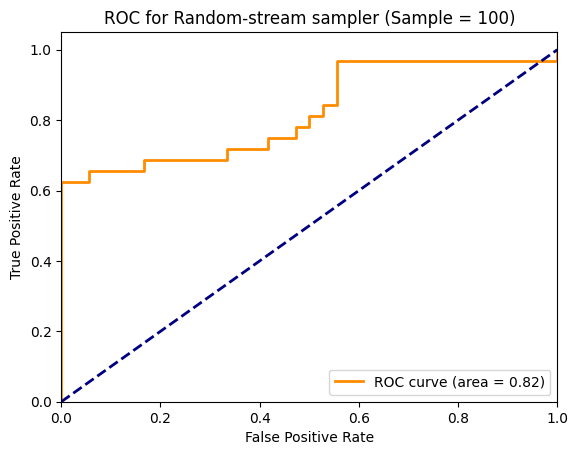

In [902]:
d_rnd = rnd_all_exp[0]
plot_roc(d_rnd[100][0], d_rnd[100][2], "Random-stream sampler (Sample = 100)")

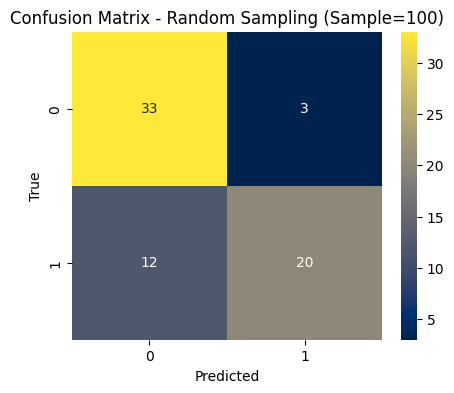

In [891]:
cms = [confusion_matrix(d_rnd[100][0], d_rnd[100][1]) for d_rnd in rnd_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(rnd_all_exp)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Random Sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [773]:
def all_auc(xrange, m_all_exp):
    iter_all_exp = []
    for exp in m_all_exp:
        # exp is a dictionary
        iter_one_exp = []
        for sample_size in xrange:
            iter_one_exp.append(roc_auc_score(exp[sample_size][0], exp[sample_size][2]))
        iter_all_exp.append(iter_one_exp)
    return iter_all_exp

In [774]:
def all_f1_score(xrange, m_all_exp):
    iter_all_exp = []
    for exp in m_all_exp:
        # exp is a dictionary
        iter_one_exp = []
        for sample_size in xrange:
            iter_one_exp.append(f1_score(exp[sample_size][0], exp[sample_size][1]))
        iter_all_exp.append(iter_one_exp)
    return iter_all_exp

In [775]:
def all_accu_score(xrange, m_all_exp):
    iter_all_exp = []
    for exp in m_all_exp:
        # exp is a dictionary
        iter_one_exp = []
        for sample_size in xrange:
            iter_one_exp.append(accuracy_score(exp[sample_size][0], exp[sample_size][1]))
        iter_all_exp.append(iter_one_exp)
    return iter_all_exp

In [924]:
f1_rnd = np.array(all_f1_score(range(24, 256), rnd_all_exp))
avg_f1_rnd = np.mean(f1_rnd, axis = 0)
std_f1 = np.std(f1_rnd, axis = 0)
print(avg_f1_rnd.shape)

(232,)


In [926]:
acc_rnd = np.array(all_accu_score(range(24, 256), rnd_all_exp))
avg_acc_rnd = np.mean(acc_rnd, axis = 0)
std_acc = np.std(acc_rnd, axis = 0)
print(avg_acc_rnd.shape)

(232,)


In [928]:
auc_rnd = np.array(all_auc(range(24, 256), rnd_all_exp))
avg_auc_rnd = np.mean(auc_rnd, axis = 0)
std_auc = np.std(auc_rnd, axis = 0)
print(avg_auc_rnd.shape)

(232,)


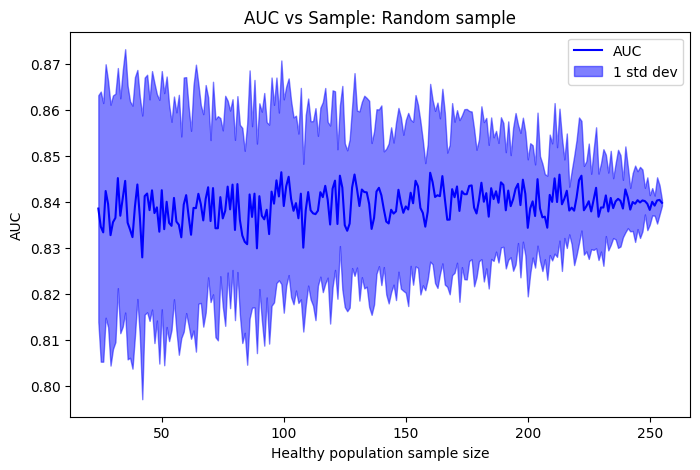

In [895]:
fill_between_plot(np.arange(24, 256, 1), [avg_auc_rnd], [std_auc], "AUC", "AUC vs Sample: Random sample")

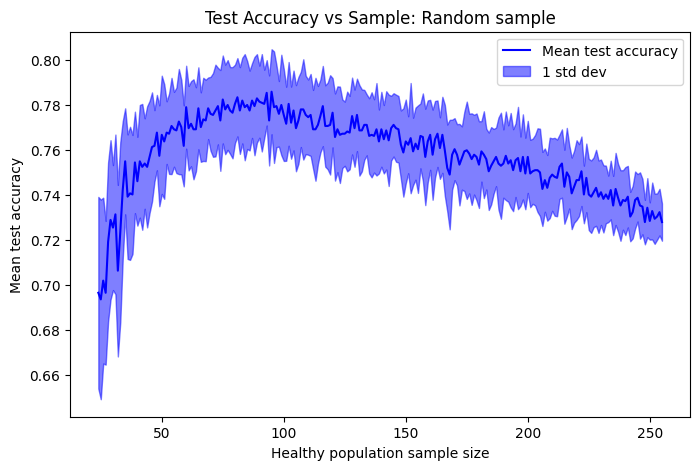

In [898]:
fill_between_plot(np.arange(24, 256, 1), [avg_acc_rnd], [std_acc], "Mean test accuracy", "Test Accuracy vs Sample: Random sample")

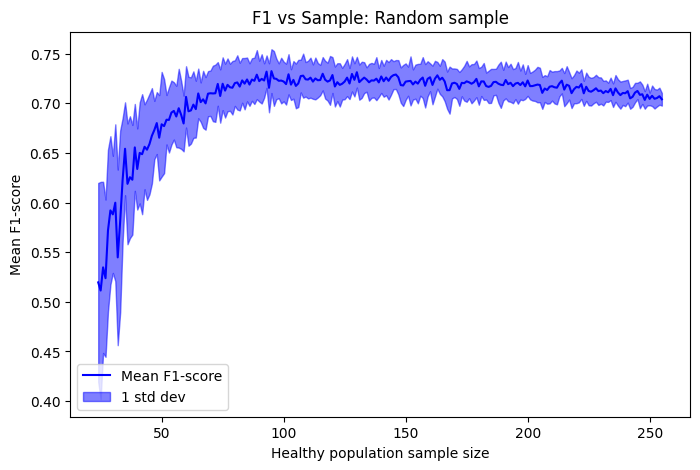

In [899]:
fill_between_plot(np.arange(24, 256, 1), [avg_f1_rnd], [std_f1], "Mean F1-score", "F1 vs Sample: Random sample")

### Method 1: Entropy-sampling 

In [708]:
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics
import re

In [709]:
# Suppress specific warnings globally
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [710]:
# since River does not support active learning with one class classifier, we define here a wrapper that converts a OCC-SVM into a binary classifier 
# Note: 0 is outlier, 1 is inlier

class OneClassSVMWrapper:
    def __init__(self, **params):
        self.model = OneClassSVM(**params)
        self.data = []
        self.is_fitted = False

    def learn_one(self, x, y=None):
        # Add the new instance to the data pool
        features = list(x.values())
        self.data.append(features)
        self.model.fit(self.data)  # Fit the model on the accumulated data
        self.is_fitted = True

    def predict_one(self, x):
        # Returns 1 for normal, 0 for anomaly
        prediction = self.predict_proba_one(x)
        return max(prediction, key = prediction.get)
    
    def minmax_probability(self, decisions, current_decision):
        # mnmx = (current_decision - min(np.min(decisions), current_decision) ) / (max(np.max(decisions), current_decision) - np.min(decisions))
        mnmx = (current_decision - np.min(decisions) ) / (np.max(decisions) - np.min(decisions))
        return mnmx
    
    def sigmoid_probability(self, decisions, current_decision):
        mean_decision = np.mean(decisions)
        std_decision = np.std(decisions)

        # Calculate the z-score of the current decision function value
        z_score = 0
        if std_decision > 0:
            z_score = (current_decision - mean_decision) / std_decision
        else:
            z_score = 0  # Avoid division by zero

        # Convert the z-score to a pseudo-probability
        # Assuming a normal distribution, we use a sigmoid function to map z-scores to [0, 1]
        sigmoid = lambda z: 1 / (1 + np.exp(-z))
        return sigmoid(z_score)

    def predict_proba_one(self, x):
        features = list(x.values())
        #if not self.is_fitted:
        #    print("Error")
        # Use decision function as a proxy; not a true probability
        decision_function = self.model.decision_function([features])[0]
        decisions = self.model.decision_function(self.data)

        # Convert decision function to a pseudo-probability
        pseudo_probability =  self.minmax_probability(decisions, decision_function)  #self.sigmoid_probability(decisions, decision_function) 
        return {0: 1 - pseudo_probability, 1: pseudo_probability}

In [711]:
# convert test_labels the 1 (healthy) and -1 (damage) to 0 (damage) and 1 (healthy) 
test_labels_es = (test_labels + 1)/2
train_labels_es = (train_labels + 1)/2

In [784]:
def testing_model_entropy_sampling(model, test_data, save_y):
    # convert labels and data to river compatible representaitions
    y_test = test_labels_es
    X_river_test = [
        {f"feature_{i}": value for i, value in enumerate(sample)}
        for sample in test_data
    ]
    y_river_test = y_test.tolist()  
    metric = metrics.Accuracy()

    preds_y = []
    preds_proba_y = []
    true_y = []

    # Process each sample in the dataset
    for i in range(len(X_river_test)):
        x = X_river_test[i]
        y_true = y_river_test[i]
        y_pred_dict, _ = model.predict_proba_one(x) 
        y_pred = max(y_pred_dict, key=y_pred_dict.get)
        metric = metric.update(y_true, y_pred)

        # return these values    
        preds_y.append(y_pred)
        true_y.append(y_true)
        preds_proba_y.append(y_pred_dict[1])

    return metric, preds_y, true_y, preds_proba_y

en_all_exp = []
# across 30 seeds
for s in range(30):
    en_dict = {}
    accuracies_train = []
    accuracies_test = []
    samples_used = []
    stop = 50000000
    step = 1
    disc = 0
    factor = 1.21
    while disc < stop:
        save_y = False
        # Prepare the data in a format compatible with river
        X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in train_data
        ]
        y_river = train_labels_es.tolist() 

        metric = metrics.Accuracy()
        base_model = OneClassSVMWrapper(nu = 0.1) 
        # if nu is set too low, then we have less training error for the OCC but then each new point we add will automatically be the one with minimum distance 
        # as a result if we set nu below 0.5 then we risk not sampling any point
        model = active.EntropySampler(base_model, discount_factor=disc, seed=s)

        n_samples_used = 0

        # Process each sample in the dataset
        for i in range(len(X_river)):
            # for the first 10 instances we only learn without updating any metric
            x = X_river[i]
            y_true = y_river[i]
            
            if i < 10:
                n_samples_used += 1
                model = model.learn_one(x, y_true)
                continue

            y_pred, ask = model.predict_one(x) 
            metric = metric.update(y_true, y_pred)

            if ask:
                n_samples_used += 1
                model = model.learn_one(x, y_true)
        
        disc =int(disc + step)
        step *= factor
        # samples_used needs to be strictly decreasing sequence 
        if n_samples_used < 20  or (len(samples_used) > 0 and (samples_used[-1] <= n_samples_used)):
            continue

        acc_train = float((re.search(r'(\d+\.\d+)', metric.__str__())).group(1))
        accuracies_train.append(acc_train)
        samples_used.append(n_samples_used)

        metric, preds_y, true_y, preds_proba_y = testing_model_entropy_sampling(model, test_data, save_y)
        # save them to the dictionary and push it 
        en_dict[n_samples_used] = [true_y, preds_y, preds_proba_y]
    en_all_exp.append(en_dict)

In [903]:
xrange = np.arange(95, 256)
auc_arr = []
acc_arr = []
f1_arr  = []
for exp in en_all_exp:
    skeys = sorted(exp.keys())
    xvals = []
    aucvals = []
    accvals = []
    f1vals  = []
    for key in skeys:
        xvals.append(key)
        truey = exp[key][0]
        predy = exp[key][1]
        proby = exp[key][2]

        # metrics
        rauc = roc_auc_score(truey, proby)
        acc = accuracy_score(truey, predy)
        f1 = f1_score(truey, predy)

        # append
        aucvals.append(rauc)
        accvals.append(acc)
        f1vals.append(f1)
    
    # interpolate and then append to the outer arrays
    f1vals = np.interp(np.arange(95, 256), xvals, f1vals)
    accvals = np.interp(np.arange(95, 256), xvals, accvals)
    aucvals = np.interp(np.arange(95, 256), xvals, aucvals)

    auc_arr.append(aucvals)
    acc_arr.append(accvals)
    f1_arr.append(f1vals)

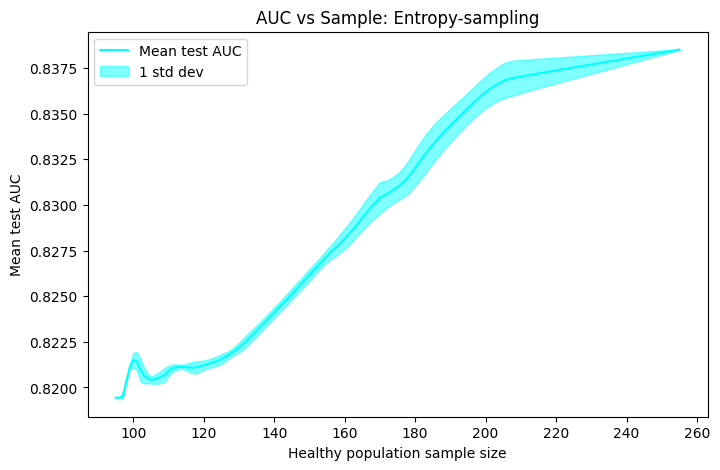

In [905]:
fill_between_plot(np.arange(95, 256), [np.mean(np.array(auc_arr), axis = 0)], [np.std(np.array(auc_arr), axis = 0)], "Mean test AUC", "AUC vs Sample: Entropy-sampling")

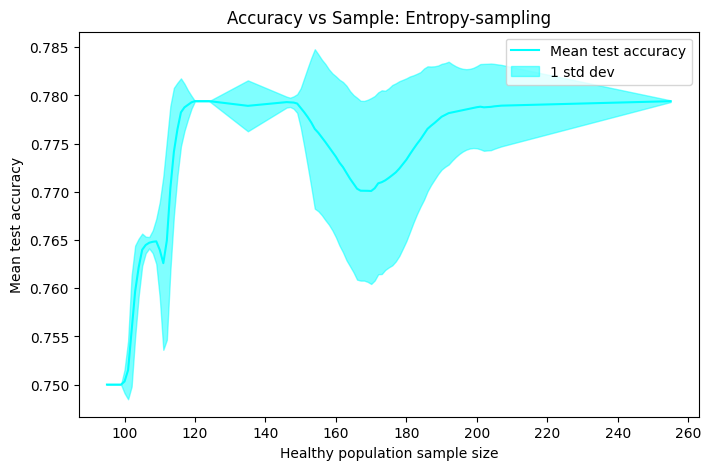

In [906]:
fill_between_plot(np.arange(95, 256), [np.mean(np.array(acc_arr), axis = 0)], [np.std(np.array(acc_arr), axis = 0)], "Mean test accuracy", "Accuracy vs Sample: Entropy-sampling")

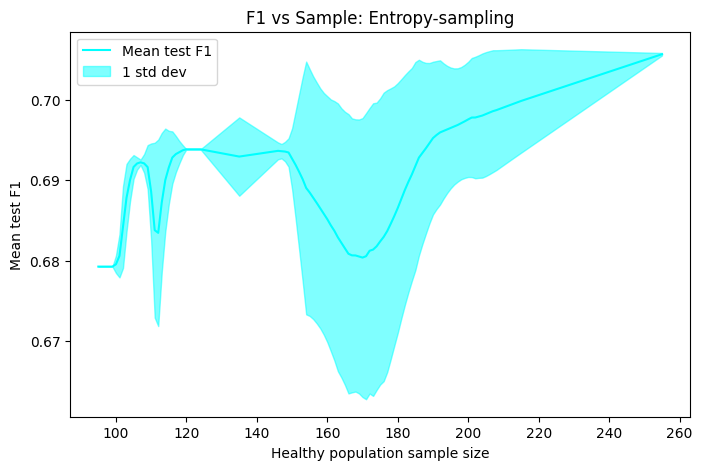

In [907]:
fill_between_plot(np.arange(95, 256), [np.mean(np.array(f1_arr), axis = 0)], [np.std(np.array(f1_arr), axis = 0)], "Mean test F1", "F1 vs Sample: Entropy-sampling")

dict_keys([256, 197, 179, 172, 170, 162, 155, 130, 119, 114, 112, 109, 107, 106, 104, 102, 100, 99, 98, 96, 95])


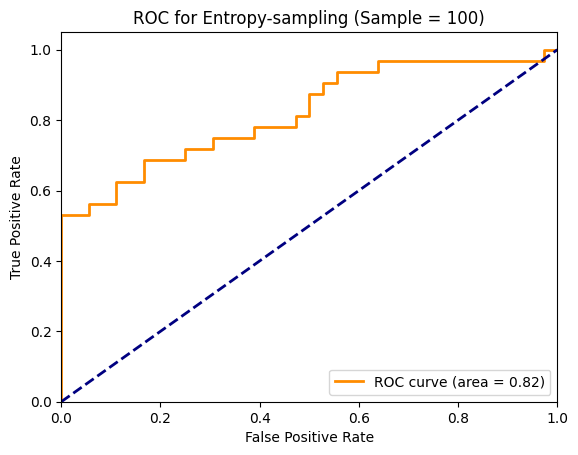

In [912]:
d_rnd = en_all_exp[0]
print(d_rnd.keys())
plot_roc(d_rnd[99][0], d_rnd[99][2], "Entropy-sampling (Sample = 100)")

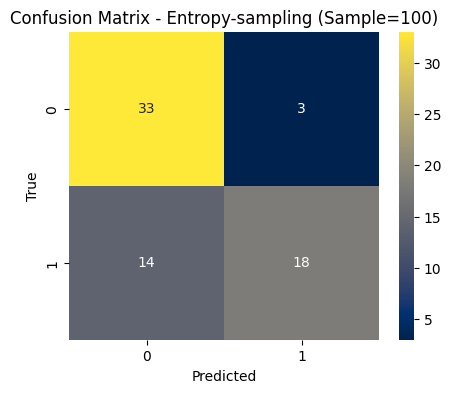

In [913]:
def find_closest_key(my_dict, target_key):
    closest_key = None
    min_diff = float('inf')

    for key in my_dict.keys():
        diff = abs(key - target_key)
        if diff < min_diff:
            min_diff = diff
            closest_key = key

    return my_dict[closest_key]

cms = [confusion_matrix(find_closest_key(d_rnd, 100)[0], find_closest_key(d_rnd, 100)[1]) for d_rnd in en_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(en_all_exp)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Entropy-sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Plot the entropy (~anomaly score)

In [447]:
def calculate_entropy(y_pred):
    probabilities = y_pred
    entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
    return entropy

In [454]:
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in train_data
]
y_river = train_labels_es.tolist() 

metric = metrics.Accuracy()
base_model = OneClassSVMWrapper(nu = 0.01)
model = active.EntropySampler(base_model, discount_factor=1, seed=42)
n_samples_used = 0
entropies = []

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]

    if i < 10:
        n_samples_used += 1
        model = model.learn_one(x, y_true)
        continue

    y_pred, ask = model.predict_proba_one(x) 
    entropy_cur = calculate_entropy(y_pred)
    entropies.append(entropy_cur)
    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

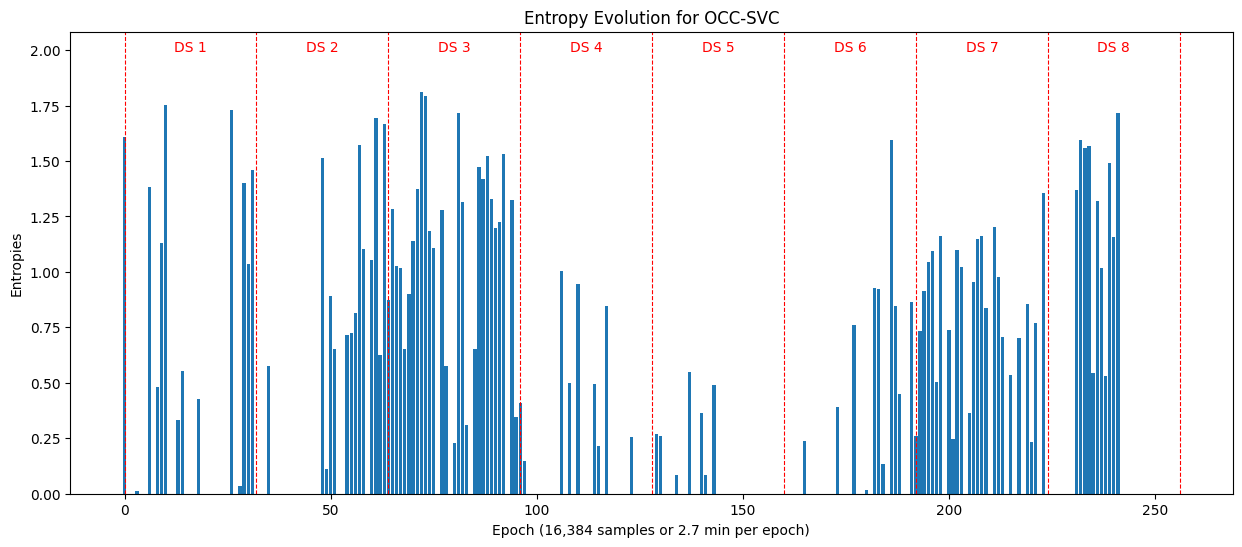

In [459]:
import matplotlib.pyplot as plt
sns.reset_defaults()
sns.reset_orig()
plt.figure(figsize=(15, 6))
nbr_epochs = 256
entropies_reshaped = np.array(entropies).reshape(-1, 1)
for i in range(0, nbr_epochs+1, 32):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)
sc = StandardScaler()
obs = np.arange(len(entropies))
std_entropies = sc.fit_transform(entropies_reshaped).flatten()
plt.bar(obs, std_entropies)
plt.ylim(0, 1.15*max(std_entropies))

plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
plt.ylabel('Entropies')
plt.title(f'Entropy Evolution for OCC-SVC')
text_pos = [i+16 for i in range(0, 256, 32)]
for idx, pos in enumerate(text_pos):
    plt.text(pos, max(std_entropies)*1.1, f'DS {idx+1}', ha='center', color='red')

plt.show()

### Method 2: Changepoint detection using Gaussian scoring

In [466]:
def gaussian_scorer_multi(y_values, window_size = 25, grace_period = 10, method = 0, plot = True):
    """
    Method: 0 if min of Gaussian anomaly scores for each variable, 1 if max of Gaussian anomaly scores, and 2 if product of scores, 3 if median of scores
    """
    from functools import reduce
    num_vals = y_values.shape[1]
    rng = random.Random(42)
    detectors = [anomaly.GaussianScorer(window_size=window_size, grace_period=grace_period) for el in range(num_vals)]
    anomaly_scores = [[0] for el in range(num_vals)]

    for idx, detector in enumerate(detectors):
        for obs_idx, y in enumerate(y_values[:-1, idx]):
            detector = detector.learn_one(None, y) 
            anomaly_scores[idx].append(detector.score_one(None, y_values[obs_idx+1, idx]))

    anomaly_scores_np = [np.array(el) for el in anomaly_scores]
    result = np.minimum.reduce(anomaly_scores_np) if method == 0 else \
         np.maximum.reduce(anomaly_scores_np) if method == 1 else reduce(np.multiply, anomaly_scores_np) if method == 2 else np.median(np.vstack(anomaly_scores_np), axis=0)
    mnmx = StandardScaler()
    obs = np.arange(len(result))
    normalized_result = mnmx.fit_transform(result.reshape(-1, 1)).flatten()
    if plot:
        import matplotlib.pyplot as plt
        sns.reset_defaults()
        sns.reset_orig()
        plt.figure(figsize=(15, 6))
        nbr_epochs = 256
        for i in range(0, nbr_epochs+1, 32):
            plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)
        plt.bar(obs, normalized_result)
        plt.ylim(0, 1.15*max(normalized_result))
        
        string_method = "min_i" if method == 0 else "max_i" if method == 1 else "\prod_i" if method == 2 else "med_i"
        plt.xlabel('Epoch (16,384 samples or 2.7 min per observation)')
        plt.ylabel('(Standardized) Gaussian anomaly score')
        plt.title(rf'Gaussian Anomaly Window: $anomaly = 2\ {string_method} \|CDF(x_i) - 0.5\|$')
        text_pos = [i+16 for i in range(0, 256, 32)]
        for idx, pos in enumerate(text_pos):
            plt.text(pos, max(normalized_result)*1.1, f'DS {idx+1}', ha='center', color='red')

        plt.show()
    return result, normalized_result

In [464]:
def plot_distribution(data, title, window = None, threshold = None, damage_zone = None):    
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    
    if window is not None:
        data = data[np.logical_and(data >= window[0], data <= window[1])]
    
    if threshold is not None and damage_zone is None:
        below_threshold = data[data < threshold]
        above_threshold = data[data >= threshold]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold, bins='auto', color='cyan', edgecolor='black', label='Above Threshold')
        plt.legend()
    elif threshold is not None and damage_zone is not None:
        below_threshold = data[data < threshold]
        above_threshold_idx = np.where(data >= threshold)[0]
        print(above_threshold_idx)
        above_threshold_damage = [data[idx] for idx in above_threshold_idx if damage_zone(idx)]
        above_threshold_nodam = [data[idx] for idx in above_threshold_idx if not damage_zone(idx)]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold_nodam, bins='auto', color='cyan', edgecolor='black', label='Above Threshold (Undamaged)')
        sns.histplot(above_threshold_damage, bins='auto', alpha = 0.6, color='red', edgecolor='black', label='Above Threshold (Damaged)')
        print(f"{len(below_threshold)} are below threshold, {len(above_threshold_damage)} are above threshold with damaged, and {len(above_threshold_nodam)} are above threshold undamaged")
        plt.legend()
    else:
        sns.histplot(data, bins='auto', color='#86bf91', edgecolor='black')
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Standardized anomaly score', fontsize=14, labelpad=15)
    plt.ylabel('Frequency', fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
    
    sns.reset_defaults()
    sns.reset_orig()

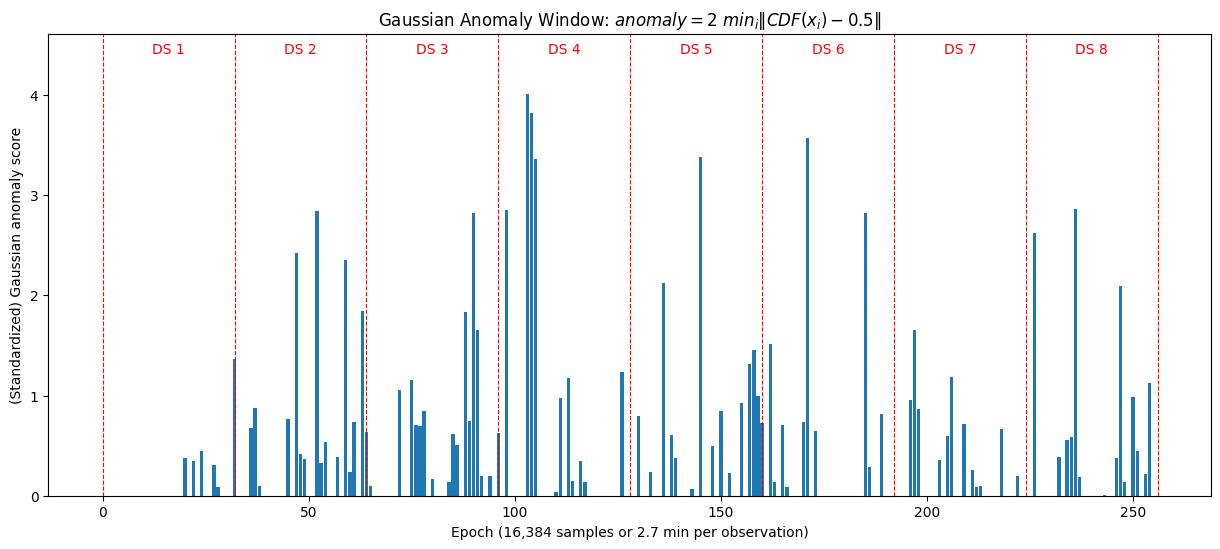

array([], dtype=int64)

In [467]:
result, n_res = gaussian_scorer_multi(train_data, window_size = 45, grace_period = 20)
np.where(n_res > 6)[0]

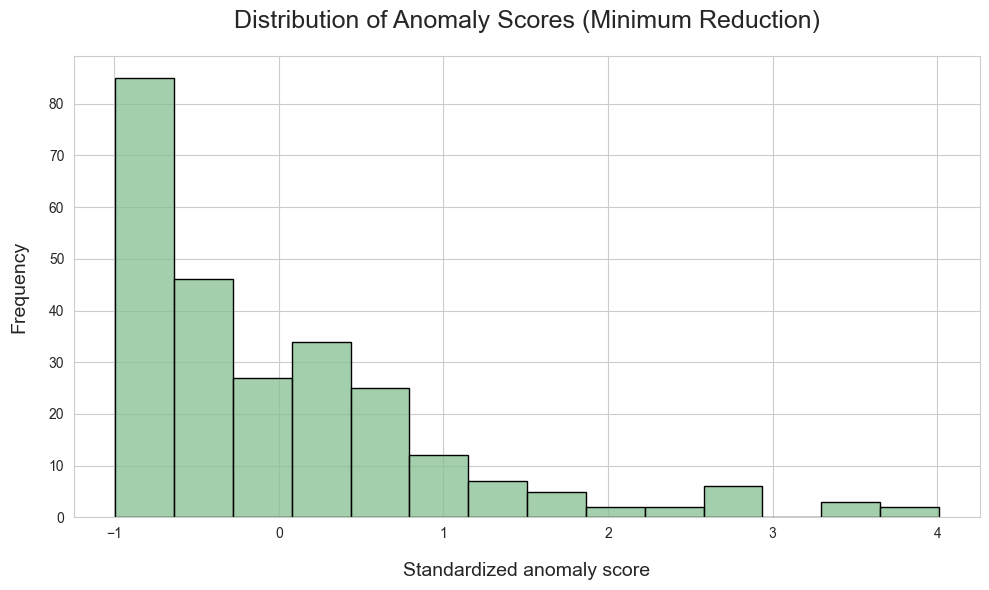

In [468]:
plot_distribution(n_res, 'Distribution of Anomaly Scores (Minimum Reduction)')

In [469]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 103)

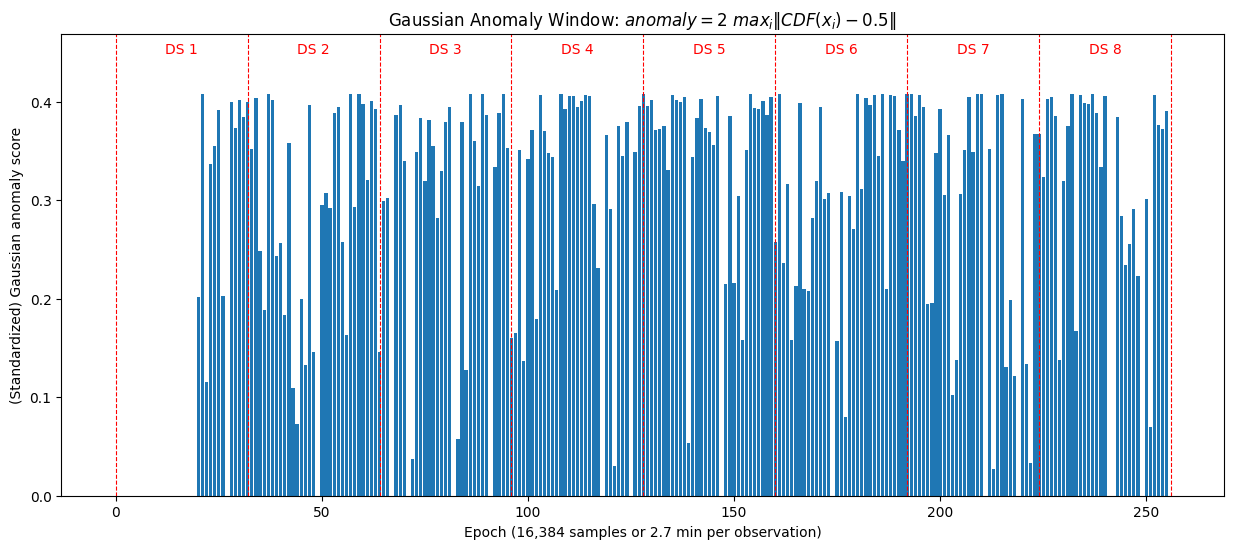

In [470]:
result, n_res = gaussian_scorer_multi(train_data, window_size = 45, grace_period = 20, method = 1) # max this time. REMARK: graph is very noisy. Taking a max is not a great idea

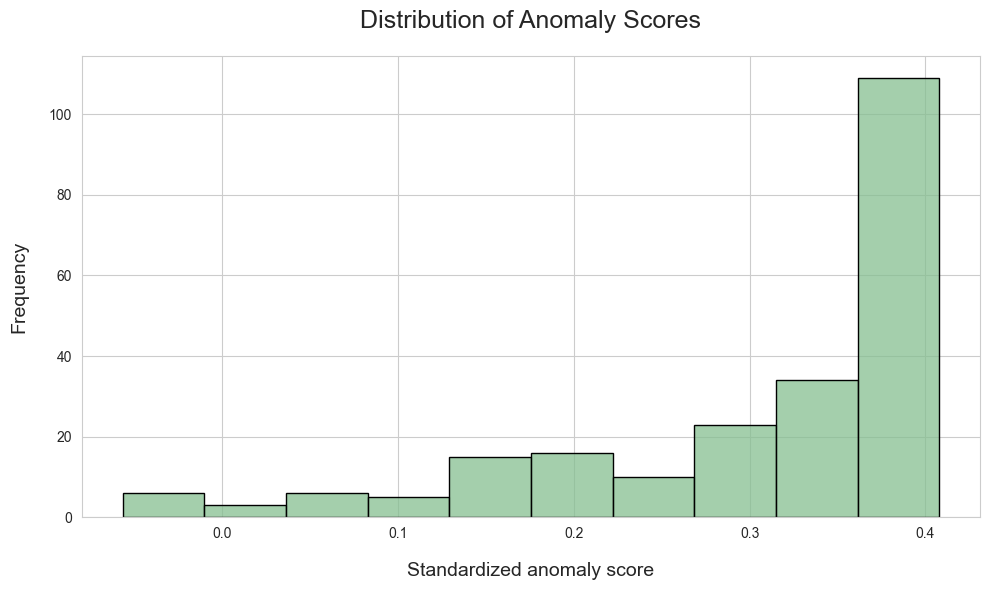

In [471]:
plot_distribution(n_res, 'Distribution of Anomaly Scores', window  = [-0.1, 1])

In [542]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 36)

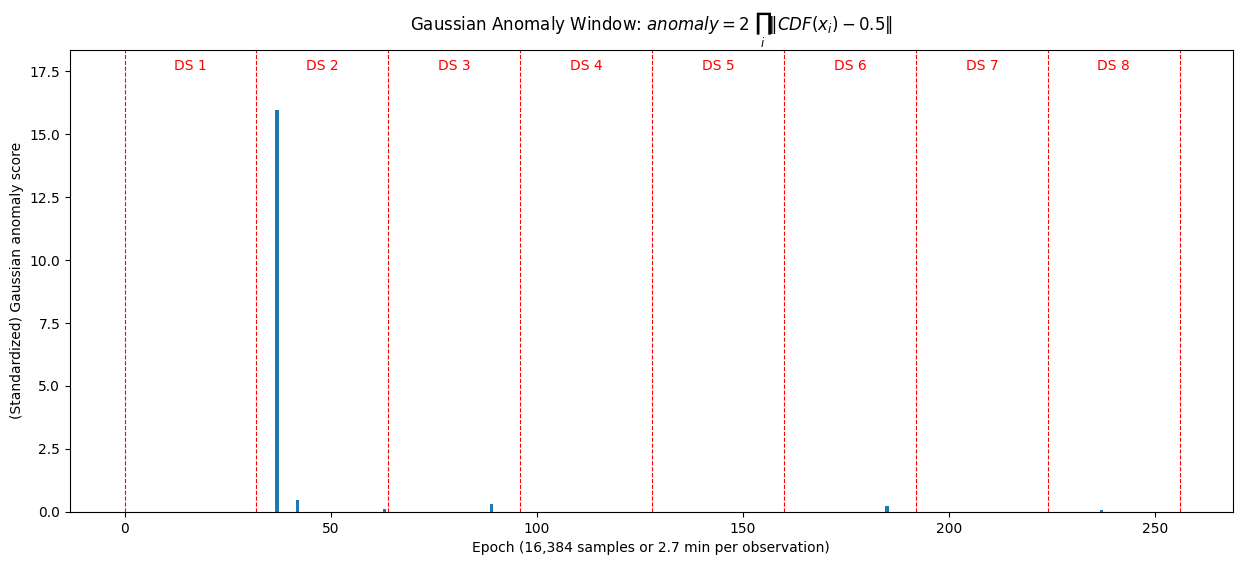

In [472]:
result, n_res = gaussian_scorer_multi(train_data, window_size =45, grace_period = 20, method = 2) # product this time

In [660]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 2.1481348189988868e-16,
 280)

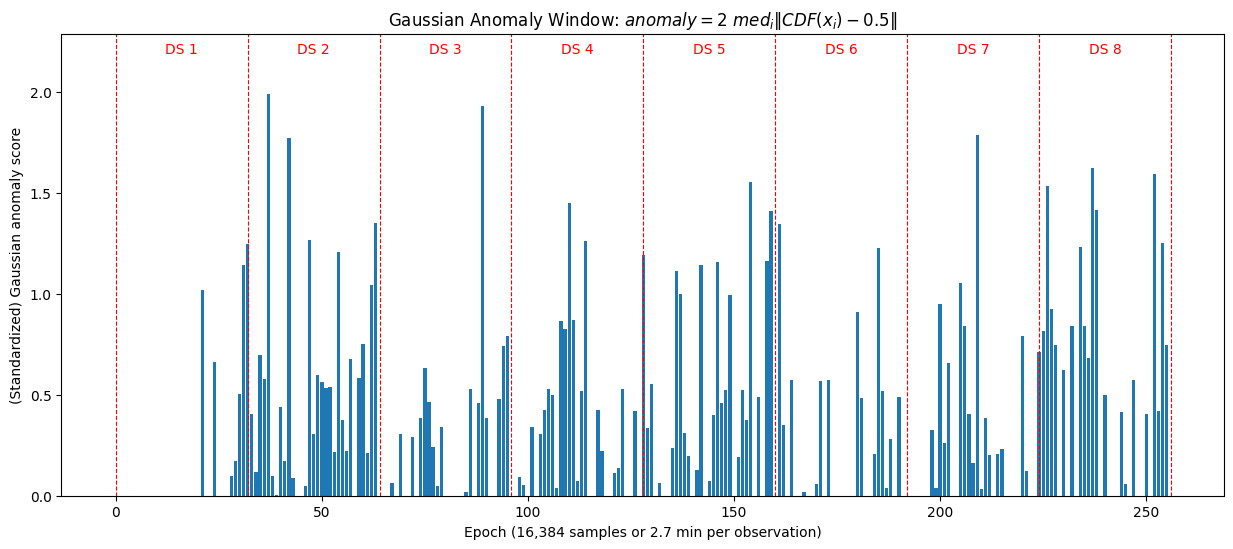

In [473]:
result, n_res = gaussian_scorer_multi(train_data, window_size = 45, grace_period = 20, method = 3) # median this time

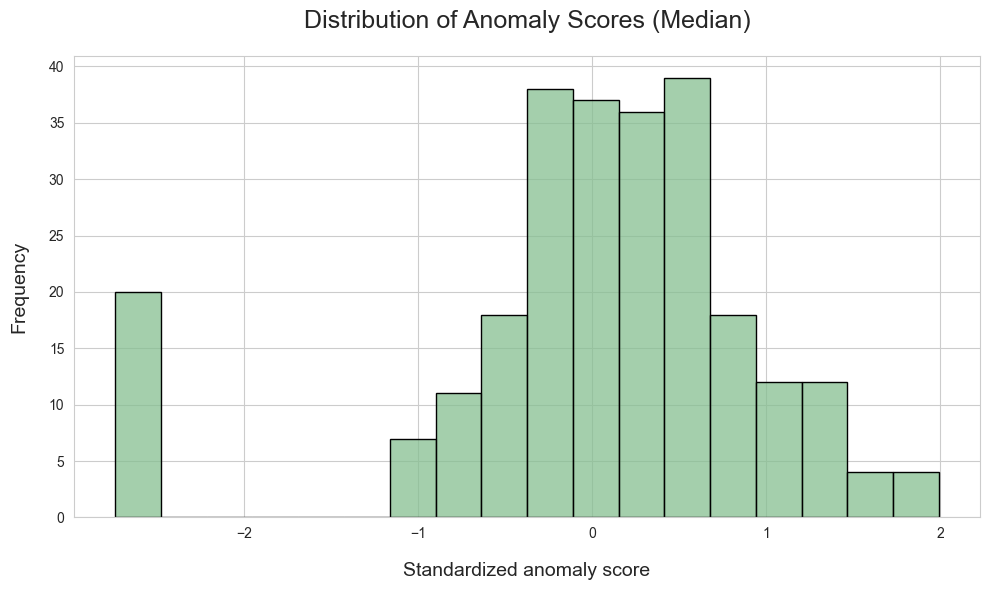

In [474]:
plot_distribution(n_res, 'Distribution of Anomaly Scores (Median)')

In [475]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 0.7958360854524518,
 37)

In [476]:
# turn these methods into AL algorithms
class AL:
    def __init__(self, anomaly_scores, threshold, labels_after_chgpt, warm_start = False):
        self.threshold = threshold
        self.anomaly_scores = anomaly_scores
        self.labels_after_chgpt = labels_after_chgpt # how many samples to query after changepoint
        self.warm_start = warm_start
    def query(self):
        self.sample_points = np.where(self.anomaly_scores >= self.threshold)[0]
        return self.sample_points # these are only start points of sampling
    def get_label_points(self): # indices of samples to label
        self.query()
        querying_points = []
        # avoid sampling across boundaries 
        def boundary(num):
            bin = num // 32
            return 32*(bin+1) - 1
        [[querying_points.append(min(num+i, boundary(num))) for i in range(self.labels_after_chgpt)] for num in self.sample_points]
        # warm start, comment the next line to avoid warm start
        if self.warm_start:
            querying_points = querying_points + list(range(10))
        res = list(set(querying_points))
        res.sort()
        return res

In [914]:
def ad_to_al_modified(normalized_res, warm_st):
    test_accuracies = []
    exp_dict = {}
    budget = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200]
    indices_ordered = np.argsort(normalized_res)[::-1]
    for i in budget:
        # get subset of data
        indices = indices_ordered[:i] if warm_st == False else np.hstack((indices_ordered[:i], np.arange(10)))
        train_data_ = train_data[indices, :]
        
        # train the model
        occsvm = OneClassSVM(nu = 0.01) 
        occsvm.fit(train_data_)
        y_pred = occsvm.predict(test_data)
        y_score = occsvm.decision_function(test_data)
        #pred_proba_y_temp = log_reg.predict_proba(X_test_top_f)[:, 1]
        
        exp_dict[i] = [test_labels, y_pred, mnmx_probs(y_score)]
        
        # accuracy
        accuracy = accuracy_score(y_test, y_pred)
        test_accuracies.append(accuracy)

    return test_accuracies, exp_dict

In [855]:
_, n_res = gaussian_scorer_multi(train_data, window_size = 45, grace_period = 20, method = 0, plot=False) # min this time
test_acc_min_gaus, exp_dict_g  = ad_to_al_modified(n_res, warm_st=True)
_, n_res_1 = gaussian_scorer_multi(train_data, window_size = 45, grace_period = 20, method = 3, plot=False) # median this time
test_acc_med_gaus, _ = ad_to_al_modified(n_res_1, warm_st=True)
_, n_res_2 = gaussian_scorer_multi(train_data, window_size = 45, grace_period = 20, method = 2, plot=False) # prod this time
test_acc_prod_gaus, _ = ad_to_al_modified(n_res_2, warm_st=True)

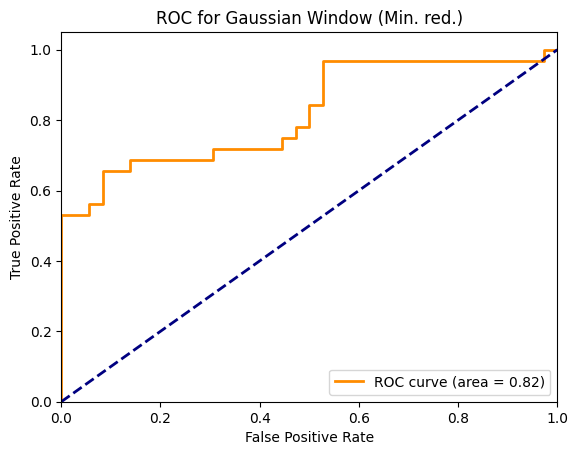

In [856]:
plot_roc(exp_dict_g[100][0], exp_dict_g[100][2], "Gaussian Window (Min. red.)")

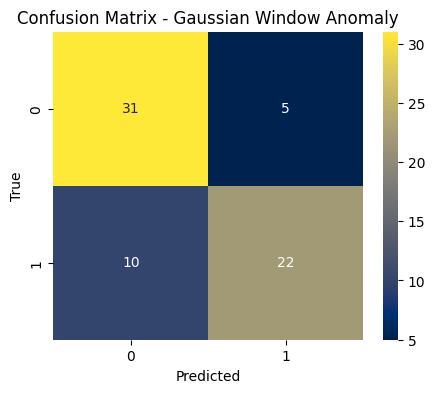

In [915]:
modes_pred = exp_dict_g[100][1]
modes_true = exp_dict_g[100][0]
cm = confusion_matrix(modes_true, modes_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Gaussian Window Anomaly")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [860]:
exp_all_g = []
for i in range(30):
    _, exp_dict_g  = ad_to_al_modified(n_res, warm_st=True)
    exp_all_g.append(exp_dict_g)

In [929]:
xrange = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200])
auc_rnd = np.array(all_auc(xrange, exp_all_g))
avg_auc_g = np.mean(auc_rnd, axis = 0)
std_auc = np.std(auc_rnd, axis = 0)

acc_rnd = np.array(all_accu_score(xrange, exp_all_g))
avg_acc_g = np.mean(acc_rnd, axis = 0)
std_acc = np.std(acc_rnd, axis = 0)

f1_rnd = np.array(all_f1_score(xrange, exp_all_g))
avg_f1_g = np.mean(f1_rnd, axis = 0)
std_f1 = np.std(f1_rnd, axis = 0)
print(avg_auc_g.shape)

(15,)


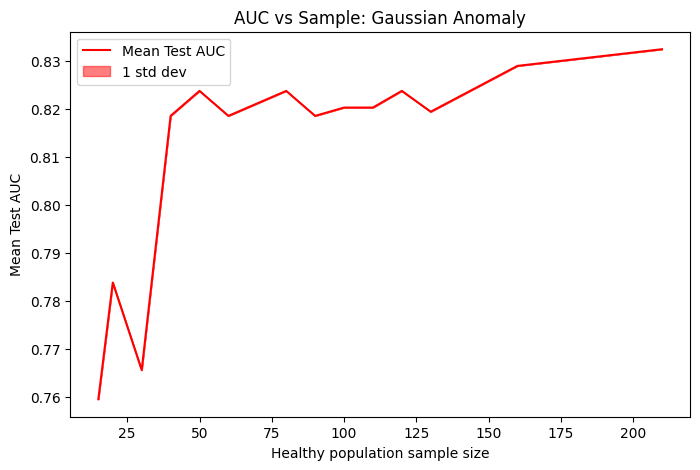

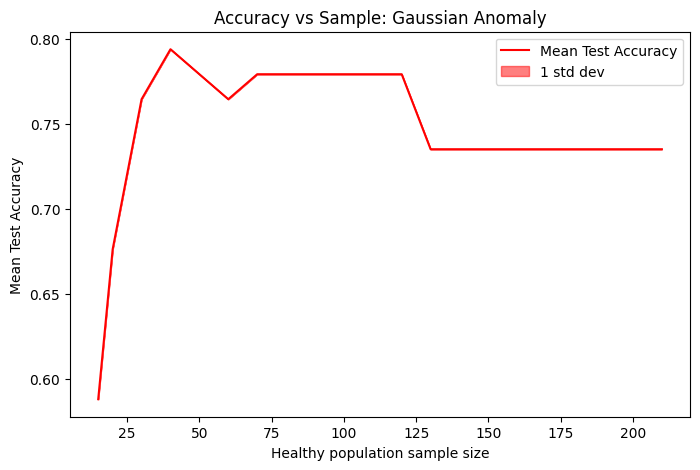

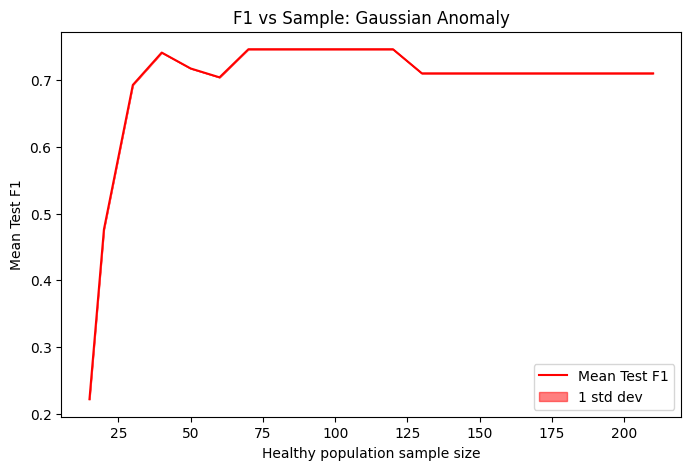

In [920]:
fill_between_plot(xrange+10, [avg_auc_g], [std_auc], "Mean Test AUC", "AUC vs Sample: Gaussian Anomaly")
fill_between_plot(xrange+10, [avg_acc_g], [std_acc], "Mean Test Accuracy", "Accuracy vs Sample: Gaussian Anomaly")
fill_between_plot(xrange+10, [avg_f1_g], [std_f1], "Mean Test F1", "F1 vs Sample: Gaussian Anomaly")

### Method 3: ARIMA

In [544]:
import pandas as pd
import numpy as np
import arimafd as oa
import sys
from io import StringIO
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from preprocess import get_avt_files, get_dataframes, preprocess_without_std

In [37]:
# get the acceleration signals
avt_files = get_avt_files("C:\\Users\\amroa\\Documents\\thesis\\data")
dfs_acc = get_dataframes(avt_files)
dfs_acc = pd.concat(dfs_acc, axis=0)
dfs_acc.reset_index(drop=True, inplace=True)
dfs_acc = dfs_acc.apply(lambda x: preprocess_without_std(x), axis=0) 
dfs_acc.shape

(10027008, 5)

In [609]:
random.seed(42)
# form a test set by taking 5 out of 
train_indices = []
test_indices  = []

for i in range(17):
    # get the indices
    test_indices_i = np.array(random.sample(range(36), 4))
    test_indices.append(i*36 + test_indices_i) # each window of a scenario is 36 long
    if i < 8:
        train_indices.append(i*36 + np.array([num for num in range(36) if num not in test_indices_i])) 

In [ ]:
batch_size = 16384 # try with half of this also
nbr_samples = dfs_acc.shape[0]
change_points = []
windows = int(nbr_samples/batch_size) #  nbr of windows
anomalies= []

for i in range(windows):
    print(f"--- iter {i} ---")
    arima = oa.Arima_anomaly_detection(ar_order=4)
    window_1 = dfs_acc[i*batch_size:(i+1)*batch_size]
    window_2 = dfs_acc[(i+1)*batch_size:(i+2)*batch_size]
    arima.fit(window_1, window = int(batch_size//2), window_insensitivity = batch_size - 1)
    ts_anomaly = arima.predict(window_2, window = int(batch_size//2), window_insensitivity= batch_size - 1)
    np.save(f"arima_{i}.npy", ts_anomaly.to_numpy())

In [610]:
# extract the relevant file indices for training and testing separately
test_indices=  np.concatenate(test_indices)
train_indices=  np.concatenate(train_indices)

In [621]:
def plot_anomalies(title, path):
    # first window always healthy
    perc_ones = [] # percent of ones in each window
    nbr_epochs = 256
    tot_epochs = 611
    for i in range(tot_epochs):
        if i in train_indices:
            if i == 0:
                perc_ones.append(0)
                continue
            cur_window = np.load(f"{path}/arima_{i}.npy")
            position_ones = np.where(cur_window == 1)[0]
            perc_ones.append(len(position_ones)/batch_size)

    scaler = StandardScaler()
    counts = scaler.fit_transform(np.array(perc_ones).reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 6)) 
    print(len(counts), np.where(counts > 3.5)[0])
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Epoch (2.7 min ~ 16,384 samples)')
    plt.ylabel('(Standardized) percent of anomalies per epoch')
    #plt.axvspan(32*4, 32*9, color='yellow', alpha=0.08)
    plt.ylim(0, 1.15*max(counts))
    plt.title(title)

    for i in range(0, nbr_epochs+1, int(nbr_epochs/8)):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    text_pos = [i+int(nbr_epochs/(2*8)) for i in range(0, nbr_epochs, int(nbr_epochs/8))]
    for idx, pos in enumerate(text_pos):
        plt.text(pos, max(counts)*0.9, f'DS {idx+1}', ha='center', color='red')

    plt.show()

    return counts

256 [ 29  64 148 187]


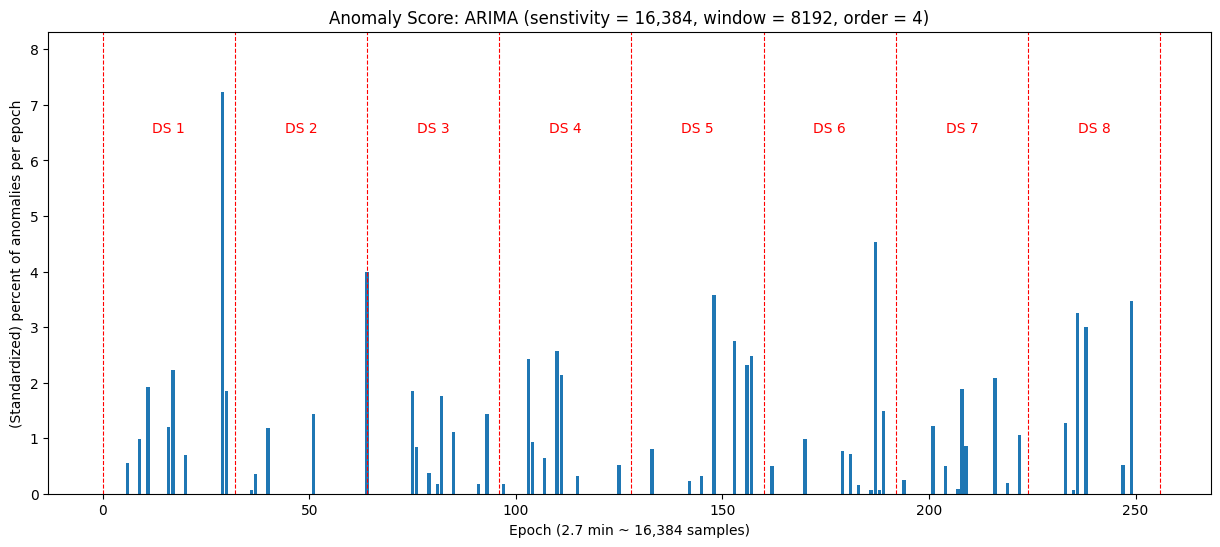

In [622]:
n_res = plot_anomalies("Anomaly Score: ARIMA (senstivity = 16,384, window = 8192, order = 4)", "./arima_16383_sens_8192_win")

256 [ 22  52 172 204]


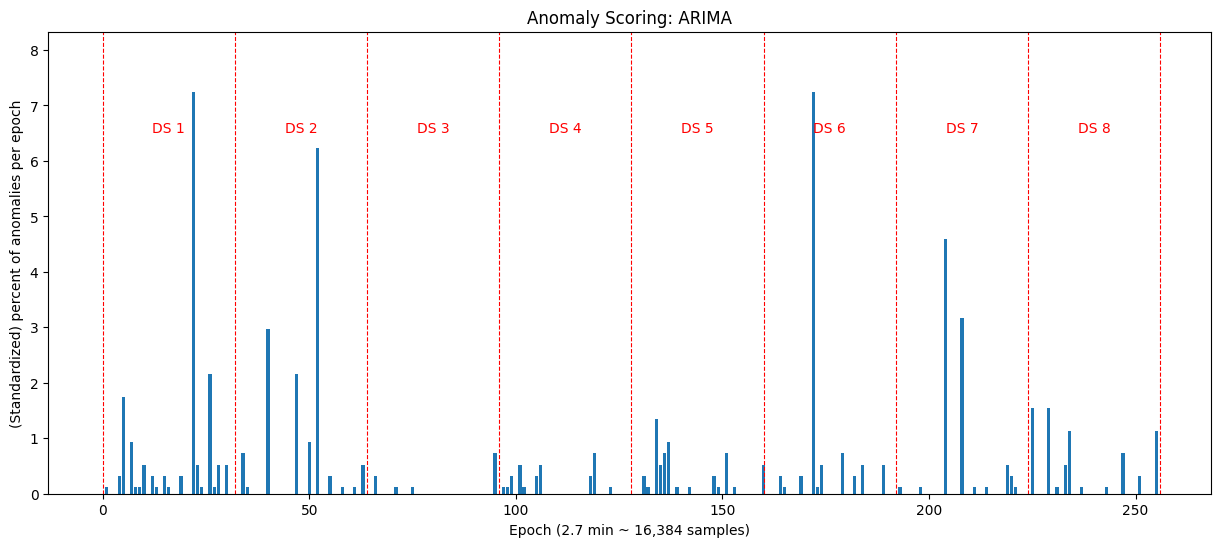

In [871]:
n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_100_sens_100_win") 

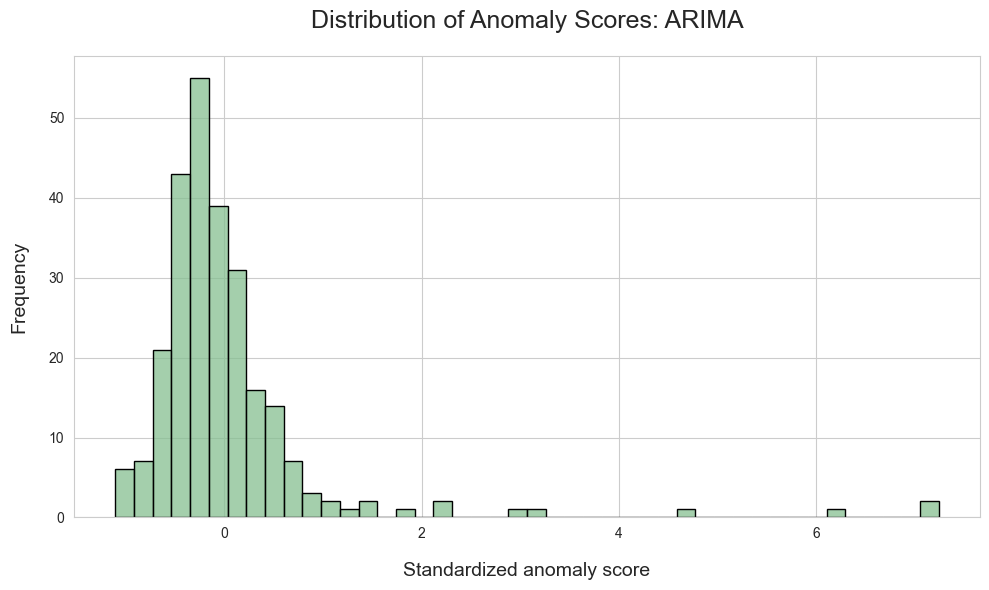

In [872]:
plot_distribution(n_res, "Distribution of Anomaly Scores: ARIMA")

In [873]:
test_acc_arima, exp_dict_ar = ad_to_al_modified(n_res, warm_st=True)

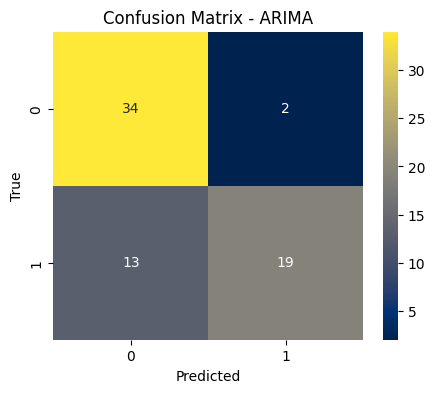

In [875]:
modes_pred = exp_dict_ar[100][1]
modes_true = exp_dict_ar[100][0]
cm = confusion_matrix(modes_true, modes_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - ARIMA")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

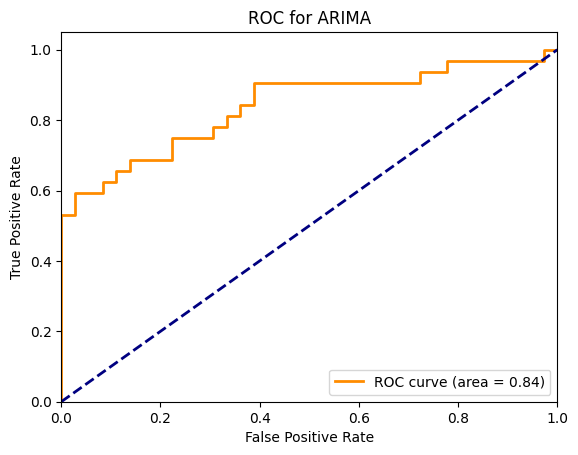

In [876]:
plot_roc(exp_dict_ar[100][0], exp_dict_ar[100][2], "ARIMA")

In [930]:
xrange = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200])
auc_rnd = np.array(all_auc(xrange, [exp_dict_ar]))
avg_auc_ar = np.mean(auc_rnd, axis = 0)
std_auc = np.std(auc_rnd, axis = 0)

acc_rnd = np.array(all_accu_score(xrange, [exp_dict_ar]))
avg_acc_ar = np.mean(acc_rnd, axis = 0)
std_acc = np.std(acc_rnd, axis = 0)

f1_rnd = np.array(all_f1_score(xrange, [exp_dict_ar]))
avg_f1_ar = np.mean(f1_rnd, axis = 0)
std_f1 = np.std(f1_rnd, axis = 0)
print(avg_auc_ar.shape)

(15,)


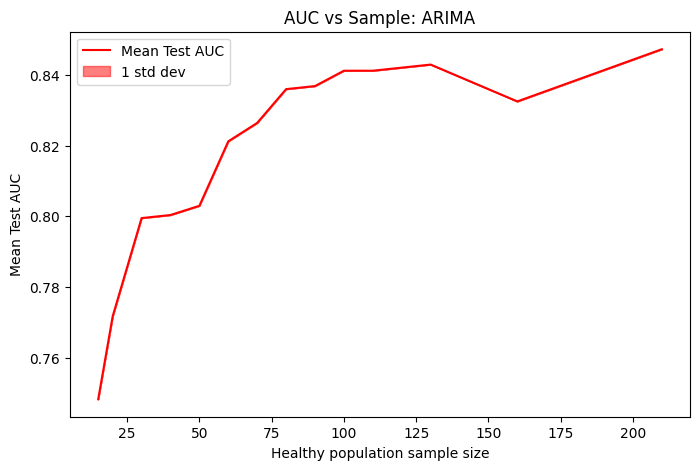

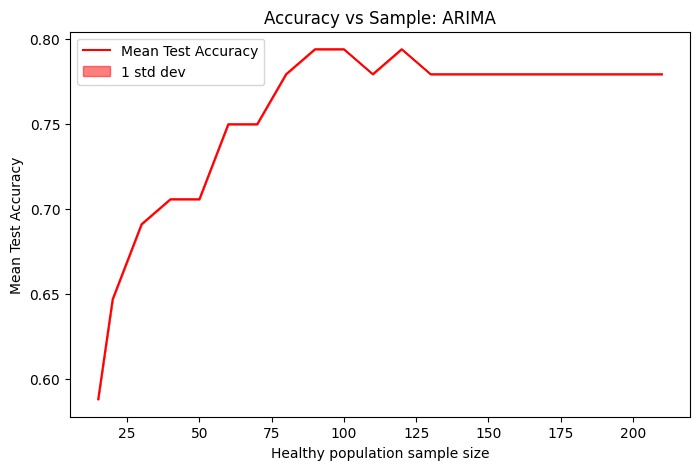

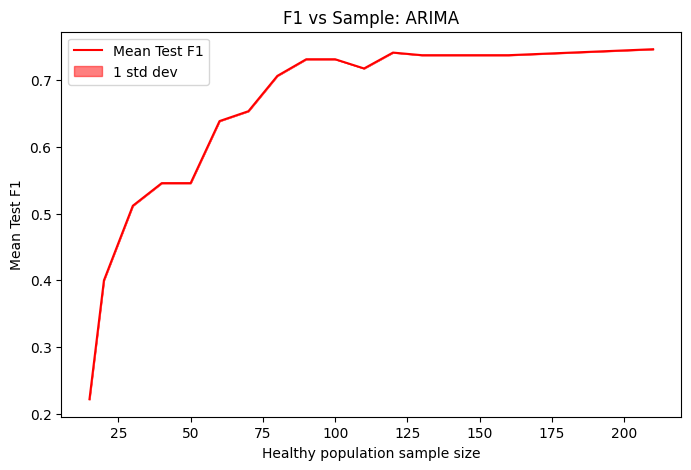

In [922]:
fill_between_plot(xrange+10, [avg_auc_ar], [std_auc], "Mean Test AUC", "AUC vs Sample: ARIMA")
fill_between_plot(xrange+10, [avg_acc_ar], [std_acc], "Mean Test Accuracy", "Accuracy vs Sample: ARIMA")
fill_between_plot(xrange+10, [avg_f1_ar], [std_f1], "Mean Test F1", "F1 vs Sample: ARIMA")

## Comparison

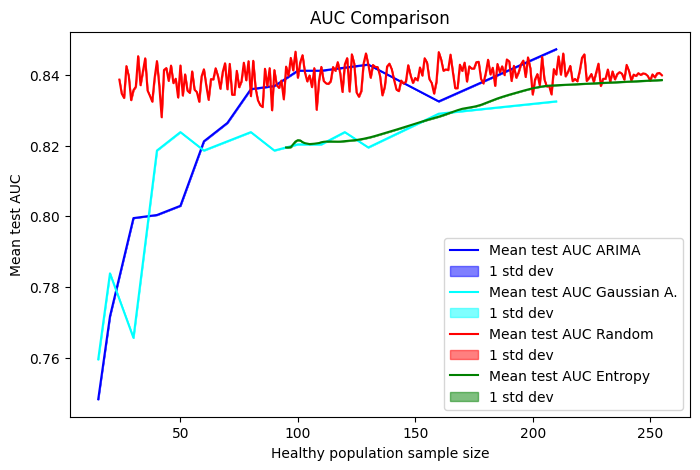

In [939]:
xrange_ad = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200]) + 10
random_range = np.arange(24, 256, 1)
xrange_en = np.arange(95, 256)

auc_en = np.mean(np.array(auc_arr), axis = 0)
fill_between_plot_diffx([xrange_ad, xrange_ad, random_range, xrange_en], [avg_auc_ar, avg_auc_g, avg_auc_rnd, auc_en], 
                        [np.zeros(len(avg_auc_ar)), np.zeros(len(avg_auc_g)), np.zeros(len(avg_auc_rnd)), np.zeros(len(auc_en))], 
                        ["Mean test AUC ARIMA", "Mean test AUC Gaussian A.", "Mean test AUC Random", "Mean test AUC Entropy"], 
                        "AUC Comparison", "Mean test AUC")

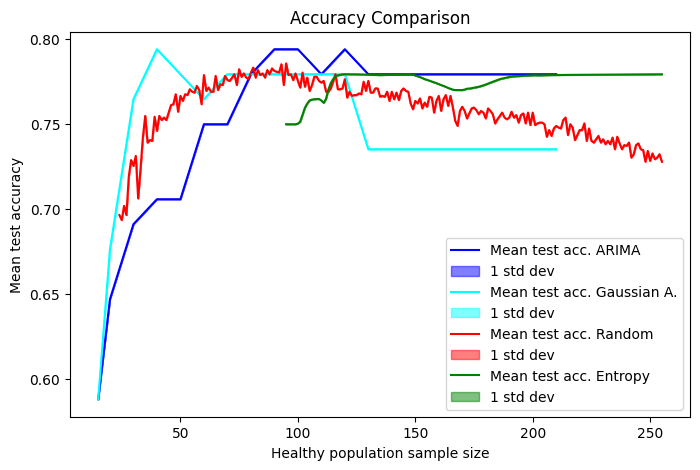

In [938]:
xrange_ad = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200]) + 10
random_range = np.arange(24, 256, 1)
xrange_en = np.arange(95, 256)

acc_en = np.mean(np.array(acc_arr), axis = 0)
fill_between_plot_diffx([xrange_ad, xrange_ad, random_range, xrange_en], [avg_acc_ar, avg_acc_g, avg_acc_rnd, acc_en], 
                        [np.zeros(len(avg_auc_ar)), np.zeros(len(avg_auc_g)), np.zeros(len(avg_auc_rnd)), np.zeros(len(auc_en))], 
                        ["Mean test acc. ARIMA", "Mean test acc. Gaussian A.", "Mean test acc. Random", "Mean test acc. Entropy"], 
                        "Accuracy Comparison", "Mean test accuracy")

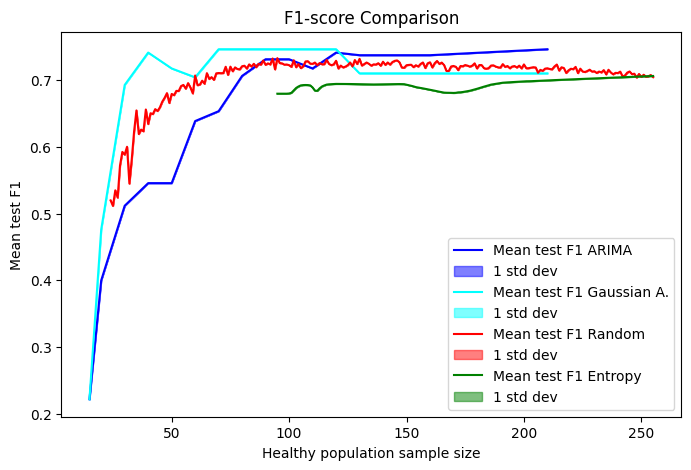

In [940]:
xrange_ad = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200]) + 10
random_range = np.arange(24, 256, 1)
xrange_en = np.arange(95, 256)

f1_en = np.mean(np.array(f1_arr), axis = 0)
fill_between_plot_diffx([xrange_ad, xrange_ad, random_range, xrange_en], [avg_f1_ar, avg_f1_g, avg_f1_rnd, f1_en], 
                        [np.zeros(len(avg_auc_ar)), np.zeros(len(avg_auc_g)), np.zeros(len(avg_auc_rnd)), np.zeros(len(auc_en))], 
                        ["Mean test F1 ARIMA", "Mean test F1 Gaussian A.", "Mean test F1 Random", "Mean test F1 Entropy"], 
                        "F1-score Comparison", "Mean test F1")